In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from tqdm import tqdm
import os
import random
import functools
import matplotlib.pyplot as plt
import time

# sklearn
from sklearn.model_selection import train_test_split, KFold

# tensorflow
import tensorflow as tf
tf.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE

# keras
import keras.backend as K

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['imet-2019-fgvc6', 'imetmetadata', 'imetpretrained', 'xception']


Using TensorFlow backend.


In [2]:
SIZE = 156
BATCH_SIZE = 64

# 1. Explore data analysis:

- This is a multi-label classification problem
- The train_val_df below contain information about label of each classes, with key to map is the image id
- Using a dataframe generated from: https://www.kaggle.com/chewzy/train-file-with-labels-and-meta-data
- This contains more detailed information of an image

In [3]:
# training dataframe
train_val_df = pd.read_csv("../input/imetmetadata/weird_images_w_labels.csv")
train_val_df.head()

,id,attribute_ids,width,height,r_mean,r_std,g_mean,g_std,b_mean,b_std,r_edge_mean,r_edge_std,g_edge_mean,g_edge_std,b_edge_mean,b_edge_std,peak_index,peak_val,culture::abruzzi,culture::achaemenid,culture::aegean,culture::afghan,culture::after british,culture::after german,culture::after german original,culture::after italian,culture::after russian original,culture::akkadian,culture::alexandria-hadra,culture::algerian,culture::alsace,culture::american,culture::american or european,culture::amsterdam,culture::ansbach,culture::antwerp,culture::apulian,culture::arabian,culture::aragon,culture::arica,...,tag::vegetables,tag::venus,tag::vestments,tag::vests,tag::victory,tag::villages,tag::vines,tag::violas,tag::violins,tag::virgin mary,tag::vishnu,tag::volcanoes,tag::vulcan,tag::wagons,tag::walking,tag::wars,tag::washing,tag::watches,tag::waterfalls,tag::watermills,tag::waves,tag::weapons,tag::weights and measures,tag::wells,tag::wind,tag::windmills,tag::windows,tag::wine,tag::winter,tag::women,tag::working,tag::world war i,tag::worshiping,tag::wreaths,tag::writing,tag::writing implements,tag::writing systems,tag::zeus,tag::zigzag pattern,tag::zodiac
0,1000483014d91860,147 616 813,339.0,300.0,193.991740,47.468273,182.179961,44.824124,169.927552,42.199740,64.077276,91.260457,63.554710,90.883635,63.069469,90.499120,707.0,0.043609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000fe2e667721fe,51 616 734 813,423.0,300.0,211.164563,47.995696,202.685390,47.376967,195.788723,47.269632,56.946785,88.436781,56.887746,88.284080,56.927352,88.050447,235.0,0.048597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1001614cb89646ee,776,365.0,300.0,149.338986,59.436609,130.213662,61.325377,120.461196,56.884549,46.891087,80.245607,46.813242,79.913449,46.527963,79.297113,581.0,0.017114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10041eb49b297c08,51 671 698 813 1092,300.0,358.0,191.176155,53.101640,175.126024,53.289562,161.795326,52.821732,58.894004,88.164013,58.830549,88.092523,58.747598,87.832953,239.0,0.031480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100501c227f8beea,13 404 492 903 1093,300.0,528.0,155.093504,52.570650,134.016162,52.261422,112.345625,49.316927,21.012077,41.658056,20.801938,41.005110,20.511275,40.086849,647.0,0.015789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
labels_df = pd.read_csv("../input/imet-2019-fgvc6/labels.csv")
labels_df.head()

,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


## 1.1. Number of classes:
- Number of classes = 1103, highly imbalanced between class labels

In [5]:
N_CLASSES = len(labels_df)
print("Number of classes:", N_CLASSES)

Number of classes: 1103


## 1.2. Images' width and height:
- All the images in the training set have width or height = 300. We're gonna prove it below

In [6]:
n_width_300 = len(train_val_df[train_val_df['width'] == 300])
n_height_300 = len(train_val_df[train_val_df['height'] == 300])
n_width_height_300 = len(train_val_df[(train_val_df['height'] == 300) & (train_val_df['width'] == 300)])

n_all_images = len(train_val_df)

print("Total images: ", n_all_images)
print("Total images with width or height = 300: ", n_height_300 + n_width_300 - n_width_height_300)

Total images:  109237
Total images with width or height = 300:  109237


- An image with width >= height will have height = 300
- An image with width <= height will have width = 300
- Or we can say the min size of an image is always 300

In [7]:
width_larger_equal_height = train_val_df[train_val_df['width'] >= train_val_df['height']]
width_smaller_equal_height = train_val_df[train_val_df['width'] < train_val_df['height']]

print("Number of image with width >= height: ", len(width_larger_equal_height))
print("Number of image with height = 300: ", sum(width_larger_equal_height['height'] == 300))
# print(n_width_smaller_height)
print("\n")
print("Number of image with width <= height: ", len(width_smaller_equal_height))
print("Number of image with width = 300: ", sum(width_smaller_equal_height['width'] == 300))

Number of image with width >= height:  51995
Number of image with height = 300:  51995


Number of image with width <= height:  57242
Number of image with width = 300:  57242


- What about test set ? The same thing happen on test set, let see if our assumption is right

In [8]:
test_ids = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')['id']
print("Total number of images in test set: ", len(test_ids))
test_ids.head()

Total number of images in test set:  7443


0    10023b2cc4ed5f68
1    100fbe75ed8fd887
2    101b627524a04f19
3    10234480c41284c6
4    1023b0e2636dcea8
Name: id, dtype: object

In [9]:
ok = True
test_datasets = tf.data.Dataset.from_tensor_slices(test_ids).map(lambda x: tf.image.decode_jpeg(
                                                                        tf.read_file("../input/imet-2019-fgvc6/test/"+x+".png")))
for img in tqdm(test_datasets):
    if((img.shape[0] != 300) & (img.shape[1] != 300)):
        print("Assumption is not right")
        ok = False
        break
        
if(ok == True):
    print("All images in test set have width or height = 300")
        

0it [00:00, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.


7443it [00:32, 227.54it/s]

All images in test set have width or height = 300


### Image with aspect ratio (width / height) > 3 or < 1/3:
- They tends to have repetitive pattern

In [10]:
train_val_df['aspect_ratio'] = train_val_df['width'] / train_val_df['height']

In [11]:
ar_larger_2 = train_val_df[(train_val_df['aspect_ratio'] > 3) & (train_val_df['height'] == 300)]
ar_larger_2['id'].head()

45     101f609f4bfff5e6
81     1037596d35059b86
185    1077816007dca731
309    10c06c5214058138
445    110b8e8c399c3194
Name: id, dtype: object

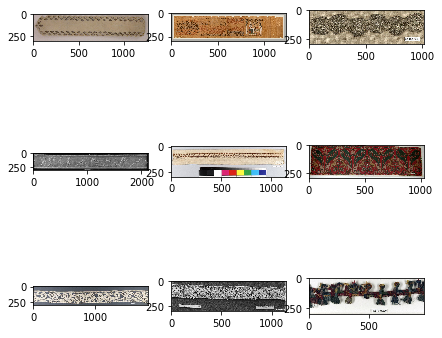

In [12]:
grids = (3, 3)
plt.figure(figsize=(7, 7))

n_plot = grids[0] * grids[1]

plot_image_names = random.choices(list(ar_larger_2['id']), k=n_plot)
plot_dataset = tf.data.Dataset.from_tensor_slices(plot_image_names).map(lambda x: tf.image.decode_jpeg(
                                                                        tf.read_file("../input/imet-2019-fgvc6/train/"+x+".png")))

for i, img in enumerate(plot_dataset):
    ax = plt.subplot(grids[0], grids[1], i+1)
    ax = plt.imshow(img, cmap='brg')
    

In [13]:
ar_smaller_1_2 = train_val_df[(train_val_df['aspect_ratio'] < 1/3.0) & (train_val_df['width'] == 300)]
ar_smaller_1_2['id'].head()

423    10fd0cfd734496e3
568    11478c8c219e7c85
607    115b1e6e5ab031bd
649    117293e5f8a0c84b
702    118ad1261e17b93b
Name: id, dtype: object

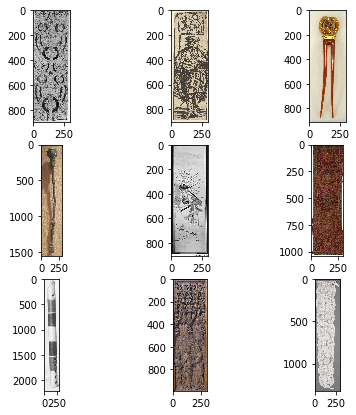

In [14]:
grids = (3, 3)
plt.figure(figsize=(7, 7))

n_plot = grids[0] * grids[1]

plot_image_names = random.choices(list(ar_smaller_1_2['id']), k=n_plot)
plot_dataset = tf.data.Dataset.from_tensor_slices(plot_image_names).map(lambda x: tf.image.decode_jpeg(
                                                                        tf.read_file("../input/imet-2019-fgvc6/train/"+x+".png")))

for i, img in enumerate(plot_dataset):
    ax = plt.subplot(grids[0], grids[1], i+1)
    ax = plt.imshow(img, cmap='brg')
    

## Image processing strategy:
- With image having size of aspect ratio > 3.0 or < 1/3.0 will be crop to size 300x300 and then resized to target size 156x156
- The others will be resized to 156x156 (no crop)

# 2. Prepare tensorflow dataset:

## 2.1. Encode label to categorical vector:
- Each label of image will be represented as a vector of shape (1, N_CLASSES)

In [15]:
categorical_labels = np.zeros(shape=(len(train_val_df['attribute_ids']), N_CLASSES))
for i, label in enumerate(train_val_df['attribute_ids']):
    list_indices = [int(k) for k in label.split(" ")]
    categorical_labels[i, list_indices] = 1
    
print(categorical_labels.shape)

(109237, 1103)


## 2.2. Some functions to create tf.data.Dataset

In [16]:
def shift_img(img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    img_shape = img.get_shape()
#     print(type(img_shape))
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1].value,
                                              width_shift_range * img_shape[1].value)
        if height_shift_range:
            height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0].value,
                                               height_shift_range * img_shape[0].value)
        # Translate both 
        output_img = tf.contrib.image.translate(img,
                                             [width_shift_range, height_shift_range])
        return output_img
    else:
        return img

def rotate_img(img, angle_range):
    rotate_angle = tf.random_uniform([], minval = angle_range[0]/180.0*3.1415, maxval=angle_range[1]/180.0*3.1415)
    out_img = tf.contrib.image.rotate(img, angles=rotate_angle)
    return out_img
    
def flip_img(horizontal_flip, img):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        out_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: tf.image.flip_left_right(img),
                                lambda: img)
        return out_img
    else:
        return img

In [17]:
def load_img_label(image_name, label):
    img_string = tf.read_file("../input/imet-2019-fgvc6/train/"+ image_name + ".png")
    img = tf.image.decode_png(img_string)
    shape = tf.shape(img)  # Use dynamic shape, only known at runtime
    tfwidth = tf.to_float(shape[1])
    tfheight = tf.to_float(shape[0])

    img = tf.cond(tf.math.logical_or(tfwidth/tfheight > 3.0, tfwidth/tfheight < 1/3.0), 
            lambda: tf.image.random_crop(img, size=[300, 300, 3]), 
            lambda: img)

    return img, label

def _augment(img,
             label,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0,   # Randomly translate the image vertically 
             rotation_range = None):  
    
    if resize is not None:
        img = tf.image.resize_images(img, resize)
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
    img = flip_img(horizontal_flip, img)
    img = shift_img(img, width_shift_range, height_shift_range)
    
    if(rotation_range):
        img = rotate_img(img, rotation_range)
    
    img = tf.to_float(img) * scale 
    return img, label

def create_dataset(filenames, 
                   labels,
                    preproc_fn=functools.partial(_augment),
                    threads=5, 
                    batch_size=BATCH_SIZE,
                    shuffle=True):

    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    
    if shuffle:
        dataset = dataset.apply(
              tf.data.experimental.shuffle_and_repeat(buffer_size=num_x))
    else:
        dataset = dataset.repeat()
        
    # load image and label from file name
    dataset = dataset.map(load_img_label)

    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        
    # It's necessary to repeat our data for all epochs 
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    
    return dataset

In [18]:
tr_cfg = {
    'resize': [SIZE, SIZE],
    'scale': 1 / 255.,
    # 'hue_delta': 0.4,
    'horizontal_flip': True,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'rotation_range': (-15,15)
}

tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)
# train_dataset = create_dataset(train_img_names, train_categorical_labels, preproc_fn=tr_preprocessing_fn, threads=2)

In [19]:
val_cfg = {
    'resize': [SIZE, SIZE],
    'scale': 1 / 255.,
}

val_preprocessing_fn = functools.partial(_augment, **val_cfg)
# val_dataset = create_dataset(val_img_names, val_categorical_labels, preproc_fn=val_preprocessing_fn, threads=2)

## 2.3. Plot some images to see our augmentation

Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

2.4585063457489014


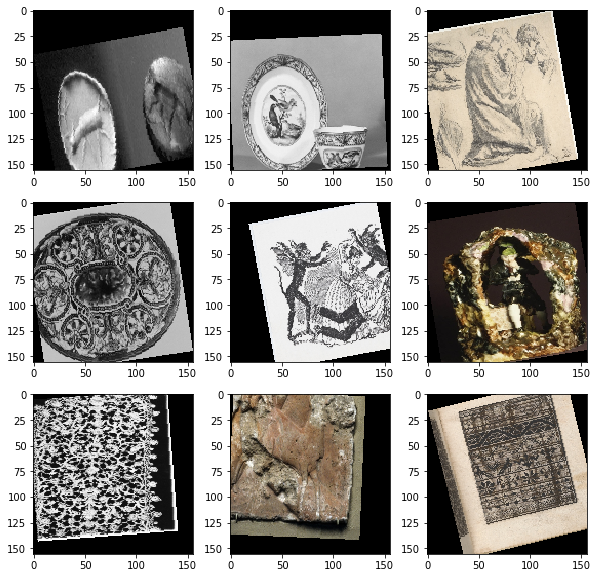

In [20]:
plot_dataset =  create_dataset(train_val_df['id'], categorical_labels, preproc_fn=tr_preprocessing_fn, threads=2, shuffle=True)
counter = 0
plt.figure(figsize=(10,10))
s = time.time()
X, y = next(plot_dataset.make_one_shot_iterator())
e = time.time()

print(e-s)

for img, label in zip(X,y):
    plt.subplot(3,3, counter+1)
    plt.imshow(img, cmap='brg')
    if(counter >= 8):
        break
    else:
        counter += 1
        

## 2.4. Function to generate Kfold cross validation data:

In [21]:
# kfold
def generate_kfolds(n_folds=10, image_names=None, categorical_labels=None):
    return KFold(n_splits=n_folds, random_state=333, shuffle=True)

# 3. Build the model:
- We will use XCeption net with no top pretrain + some custom top layers
- Loss: focal loss
- Metrics: f2_score
- We will warm up the training by freeze all the layers of Xception net and train only our custom ones
- Finally, set all layers' trainability = True and fine tuning

In [22]:
# Loss

gamma = 2.0
epsilon = tf.keras.backend.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = tf.keras.backend.clip(pt, epsilon, 1-epsilon)
    CE = -tf.log(pt)
    FL = tf.pow(1-pt, gamma) * CE
    loss = tf.keras.backend.sum(FL, axis=1)
    return loss

# Metric
def f2_score(y_true, y_pred):
    beta = 2
    true_positives = tf.keras.backend.sum(tf.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)), axis=1)
    predicted_positives = tf.keras.backend.sum(tf.round(tf.keras.backend.clip(y_pred, 0, 1)), axis=1)
    possible_positives = tf.keras.backend.sum(tf.round(tf.keras.backend.clip(y_true, 0, 1)), axis=1)
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    return tf.keras.backend.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+tf.keras.backend.epsilon()))

## 3.1. Model architecture:

In [23]:
custom_weight = True
training = False

In [24]:
def create_model(input_shape, n_out):
    input_tensor = tf.keras.layers.Input(shape=input_shape)
    base_model = tf.keras.applications.Xception(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    if(not custom_weight):
        base_model.load_weights('../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
#     x = Conv2D(32, kernel_size=(1,1), activation='relu')(base_model.output)
#     x = Flatten()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    # x = Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # x = Dropout(0.5)(x)
    final_output = tf.keras.layers.Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = tf.keras.Model(input_tensor, final_output)
    if(custom_weight):
        model.load_weights('../input/imetpretrained/imet_xception_val_f2_0.686829-f2_0.611568.h5')
        
    return model

In [25]:
model = create_model(input_shape=(SIZE, SIZE, 3), n_out=N_CLASSES)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156, 156, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 77, 77, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 77, 77, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 77, 77, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## 3.2. Call backs on training progress:

In [26]:
# create callbacks list
checkpoint = tf.keras.callbacks.ModelCheckpoint('../working/imet_xception_val_f2_{val_f2_score:3f}-f2_{f2_score:3f}.h5',
                                                monitor='val_loss', verbose=1, save_best_only=True, mode='min', 
                                                save_weights_only = True)
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = tf.keras.callbacks.CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]

## 3.3. Training:
- We will first freeze convolution layer of exception nets and train only newly added ones. If we have custom weights that are already trained, the step is simply skipped.
- Then the second steps is to set all the net layers to be trainable and fine tune with several epochs

In [ ]:
# warm up model
if(training and not custom_weight):
    n_folds = 10

    for layer in model.layers:
        layer.trainable = False

    for i in range(-5,0):
        model.layers[i].trainable = True

    model.compile(
        loss=focal_loss,
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=[f2_score])

    kfolder = generate_kfolds(n_folds, image_names=train_val_df['id'], categorical_labels=categorical_labels)
    list_loss = []
    list_f2 = []

    for i, (train_indices, val_indices) in enumerate(kfolder.split(train_val_df['id'], categorical_labels)):
        print("============== Fold", (i+1), "================")
        train_dataset = create_dataset(train_val_df.loc[train_indices, 'id'], categorical_labels[train_indices, :], preproc_fn=tr_preprocessing_fn, threads=2)
        val_dataset = create_dataset(train_val_df.loc[val_indices, 'id'], categorical_labels[val_indices, :], preproc_fn=val_preprocessing_fn, threads=2)
        history = model.fit_generator(
            train_dataset,
            steps_per_epoch=int(np.ceil(float(len(train_indices)) / float(BATCH_SIZE))),
            validation_data=val_dataset,
            validation_steps=int(np.ceil(float(len(val_indices)) / float(BATCH_SIZE))),
            epochs=1,
            verbose=1,
            callbacks=callbacks_list)
        list_loss.append(history.history['val_loss'][0])
        list_f2.append(history.history['val_f2_score'][0])
        print("Val loss of fold %d = %f"%(i+1, history.history['val_loss'][0]))
        print("F2 score of fold %d = %f"%(i+1, history.history['val_f2_score'][0]))

    print("\nMean val loss over all: ", np.mean(np.array(list_loss)))
    print("Mean f2_score over all: ", np.mean(np.array(list_f2)))

In [ ]:
# train all layers - finetuning
if(training):
    n_folds = 15

    for layer in model.layers:
        layer.trainable = True

    model.compile(loss=focal_loss,
                optimizer=tf.keras.optimizers.Adam(lr=0.0003),
                 metrics=[f2_score])

    checkpoint = tf.keras.callbacks.ModelCheckpoint('../working/imet_xception_val_f2_{val_f2_score:3f}-f2_{f2_score:3f}.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, 
                                                    mode='min', save_weights_only = True)
    reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, 
                                       verbose=1, mode='auto', epsilon=0.0001)
    early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                          mode="min", 
                          patience=9)
    callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]

    print("Start training ...")

    kfolder = generate_kfolds(n_folds, image_names=train_val_df['id'], categorical_labels=categorical_labels)
    list_loss = []
    list_f2 = []

    for i, (train_indices, val_indices) in enumerate(kfolder.split(train_val_df['id'], categorical_labels)):
        print("============== Fold", (i+1), "================")
        train_dataset = create_dataset(train_val_df.loc[train_indices, 'id'], categorical_labels[train_indices, :], preproc_fn=tr_preprocessing_fn, threads=2)
        val_dataset = create_dataset(train_val_df.loc[val_indices, 'id'], categorical_labels[val_indices, :], preproc_fn=val_preprocessing_fn, threads=2)
        history = model.fit_generator(
            train_dataset,
            steps_per_epoch=int(np.ceil(float(len(train_indices)) / float(BATCH_SIZE))),
            validation_data=val_dataset,
            validation_steps=int(np.ceil(float(len(val_indices)) / float(BATCH_SIZE))),
            epochs=1,
            verbose=1,
            callbacks=callbacks_list)
        list_loss.append(history.history['val_loss'][0])
        list_f2.append(history.history['val_f2_score'][0])
        print("Val loss of fold %d = %f"%(i+1, history.history['val_loss'][0]))
        print("F2 score of fold %d = %f"%(i+1, history.history['val_f2_score'][0]))

    print("\nMean val loss over all: ", np.mean(np.array(list_loss)))
    print("Mean f2_score over all: ", np.mean(np.array(list_f2)))

# 4. Prediction and submit

In [ ]:
submit = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')
predicted = []

In [ ]:
# load the best score model
def file_filter(filename):
    return filename.startswith('imet_xception')

if(training):
    model_files = list(filter(file_filter, os.listdir('../working/')))
    model_files = sorted(model_files)

    weight_path = os.path.join("../working/", model_files[-1])
    print("Current weight path for prediction: ", weight_path)
    
    model.load_weights(weight_path)

In [ ]:
'''Search for the best threshold regarding the validation set'''
BATCH = 512
check_dataset = create_dataset(train_val_df['id'], categorical_labels, preproc_fn=val_preprocessing_fn, threads=2)

counter = 0
n_val = round(len(train_val_df)*0.5//BATCH)
print(n_val)

lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

for X, y in tqdm(check_dataset): 
    if(counter >= n_val):
        break
    else:
        counter += 1
    
    y_pred = model.predict(X.numpy())
    lastFullValPred = np.append(lastFullValPred, y_pred, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, y, axis=0)
    

print(lastFullValPred.shape, lastFullValLabels.shape)

In [ ]:
beta_f2 = 2
def my_f2(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + 1e-15)

    return f2

def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in tqdm(thrs):
        score.append(my_f2(targs, (preds > thr).astype(int) ))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

In [ ]:
best_thr, best_score = find_best_fixed_threshold(lastFullValPred, lastFullValLabels, do_plot=True)

In [ ]:
def load_img(img_name):
    path = '../input/imet-2019-fgvc6/test/'+ img_name +".png"
    img_string = tf.read_file(path)
    img = tf.image.decode_png(img_string)
    shape = tf.shape(img)  # Use dynamic shape, only known at runtime
    tfwidth = tf.to_float(shape[1])
    tfheight = tf.to_float(shape[0])

    img = tf.cond(tf.math.logical_or(tfwidth/tfheight > 3.0, tfwidth/tfheight < 1/3.0), 
            lambda: tf.image.random_crop(img, size=[300, 300, 3]), 
            lambda: img)
    
    img = tf.image.resize(img, (SIZE, SIZE))
    img = tf.to_float(img) / 255.0
    return img

In [ ]:
submit_ds = tf.data.Dataset.from_tensor_slices(submit['id'])
submit_ds = submit_ds.apply(tf.data.experimental.map_and_batch(map_func=load_img, batch_size=BATCH_SIZE))

In [ ]:
predictions = model.predict_generator(submit_ds, steps = int(np.ceil(len(submit['id']) / BATCH_SIZE)), verbose=1)

In [ ]:
label_indices = []
for raw_pred in predictions:
    label_predict = np.arange(N_CLASSES)[raw_pred>=best_thr]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    label_indices.append(str_predict_label)

In [ ]:
submit['attribute_ids'] = label_indices
submit.to_csv('submission.csv', index=False)

In [ ]:
submit['attribute_ids'].head()

In [ ]:
submit['attribute_ids'].map(lambda row: len(row.split(" "))).value_counts()